In [1]:
import numpy as np
import torch
import scanpy as sc
from data import PertDataloader, Network


name2path = {
    'GNN_Disentangle-L2': 'GNN_Disentangle_GAT_string_20.0_64_2_l2_Norman2019_gene_emb_pert_emb_constant_sim_gnn',
    'GNN_Disentangle_Sim': 'GNN_Disentangle_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_sim_gnn',
    'GNN_Disentangle_Sim_No_Gene': 'GNN_Disentangle_sim_gnn', 
    'No-Perturb': 'No_Perturb_GAT_string_20.0_64_2_l3_Norman2019_gamma2_gene_emb_pert_emb_constant_sim_gnn'
}


name = 'GNN_Disentangle_Sim_No_Gene'

model_name = name2path[name]
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['device'] = 'cuda:3'

In [2]:
#import wandb
#wandb.init(project='pert_gnn_simulation', entity='kexinhuang', name=name)

In [3]:
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if args['dataset'] == 'Norman2019':
    data_path = '/dfs/project/perturb-gnn/datasets/Norman2019_hvg+perts_more_de.h5ad'

adata = sc.read_h5ad(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 101013 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [6]:
args['uncertainty'] = False
args['no_pert_emb'] = False
args['batchnorm'] = False
args['skipsum'] = False
args['no_disentangle'] = False

In [9]:
model = torch.load('./saved_models/' + model_name)
#model.pert_emb_agg = 'constant'
#model.lambda_emission = False
#model.sim_gnn = False
model.args = args
model.uncertainty = False
from torch.nn import ReLU
model.act = ReLU()
from inference import evaluate, compute_metrics, deeper_analysis, GI_subgroup

test_res = evaluate(pertdl.loaders['test_loader'],
                        pertdl.loaders['edge_index'],
                        pertdl.loaders['edge_attr'], model, args)

test_metrics, test_pert_res = compute_metrics(test_res)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/dfs/user/kexinh/miniconda3/

In [ ]:
import pickle
metrics = ['mse', 'mae', 'spearman', 'pearson', 'r2']
for m in metrics:
    wandb.log({'test_' + m: test_metrics[m],
               'test_de_'+m: test_metrics[m + '_de']                     
              })
subgroup_path = './splits/Norman2019_simulation_1_0.1_subgroup.pkl'
subgroup = pickle.load(open(subgroup_path, "rb"))
        
subgroup_analysis = {}
for name in subgroup['test_subgroup'].keys():
    subgroup_analysis[name] = {}
    for m in list(list(test_pert_res.values())[0].keys()):
        subgroup_analysis[name][m] = []

for name, pert_list in subgroup['test_subgroup'].items():
    for pert in pert_list:
        for m, res in test_pert_res[pert].items():
            subgroup_analysis[name][m].append(res)

for name, result in subgroup_analysis.items():
    for m in result.keys():
        subgroup_analysis[name][m] = np.mean(subgroup_analysis[name][m])
        wandb.log({'test_' + name + '_' + m: subgroup_analysis[name][m]})

        print('test_' + name + '_' + m + ': ' + str(subgroup_analysis[name][m]))

In [10]:
out = deeper_analysis(adata, test_res)
GI_out = GI_subgroup(out)

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user

/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: divide by zero encountered in true_divide
  fold_change = pert_mean/ctrl
/dfs/user/kexinh/perturb_GNN/kexin/inference.py:264: RuntimeWarning: invalid value encountered in true_divide
  fold_change = pert_mean/ctrl


/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'frac_in_range_25_75')

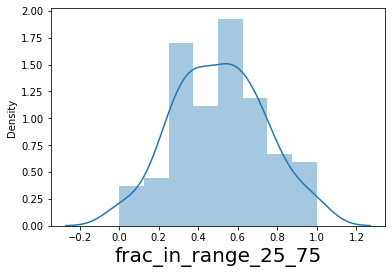

In [11]:
import seaborn as sns
ax = sns.distplot([i['frac_in_range_25_75'] for i in out.values() if 'frac_in_range_25_75' in i])
ax.set_xlabel('frac_in_range_25_75', fontsize = 20)

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'frac_sigma_below_1')

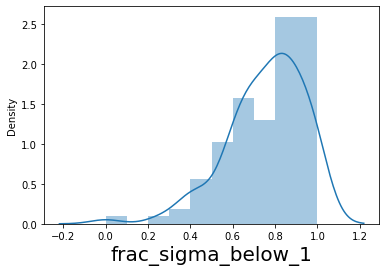

In [13]:
ax = sns.distplot([i['frac_sigma_below_1'] for i in out.values() if 'frac_sigma_below_1' in i])
ax.set_xlabel('frac_sigma_below_1', fontsize = 20)

In [20]:
[i for i,j in out.items() if ('frac_sigma_below_1' in j) and (j['frac_sigma_below_1'] < 0.7)]

['ARID1A+ctrl',
 'BCORL1+ctrl',
 'CBL+CNN1',
 'CBL+PTPN12',
 'CBL+TGFBR2',
 'CBL+UBASH3B',
 'CDKN1C+CDKN1A',
 'CDKN1C+CDKN1B',
 'CEBPB+CEBPA',
 'CKS1B+ctrl',
 'COL2A1+ctrl',
 'DUSP9+ETS2',
 'DUSP9+IGDCC3',
 'DUSP9+KLF1',
 'DUSP9+PRTG',
 'DUSP9+SNAI1',
 'DUSP9+ctrl',
 'FEV+ISL2',
 'FEV+MAP7D1',
 'FOSB+CEBPB',
 'FOXA3+FOXL2',
 'FOXL2+HOXB9',
 'IRF1+SET',
 'ISL2+ctrl',
 'KLF1+COL2A1',
 'MAP2K6+SPI1',
 'PTPN12+SNAI1',
 'PTPN12+UBASH3A',
 'PTPN12+ZBTB25',
 'SET+ctrl',
 'SPI1+ctrl',
 'TBX3+TBX2',
 'UBASH3B+PTPN12',
 'ZBTB10+PTPN12',
 'ctrl+COL2A1',
 'ctrl+PTPN12']

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'pearson_delta_top50_de')

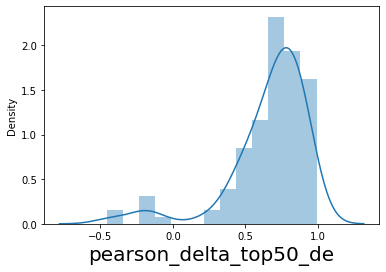

In [8]:
import seaborn as sns
ax = sns.distplot([i['pearson_delta_top50_de'] for i in out.values() if 'pearson_delta_top50_de' in i])
ax.set_xlabel('pearson_delta_top50_de', fontsize = 20)

In [7]:
metrics = ['frac_in_range', 'frac_in_range_45_55', 'frac_in_range_40_60', 'frac_in_range_25_75', 'mean_sigma', 'std_sigma', 'frac_sigma_below_1', 'frac_sigma_below_2', 'pearson_delta',
               'pearson_delta_de', 'fold_change_gap_all', 'pearson_delta_top200_hvg', 'fold_change_gap_upreg_3', 
               'fold_change_gap_downreg_0.33', 'fold_change_gap_downreg_0.1', 'fold_change_gap_upreg_10', 
               'pearson_top200_hvg', 'pearson_top200_de', 'pearson_top20_de', 'pearson_delta_top200_de', 
               'pearson_top100_de', 'pearson_delta_top100_de', 'pearson_delta_top50_de', 'pearson_top50_de', 'pearson_delta_top20_de',
               'mse_top200_hvg', 'mse_top100_de', 'mse_top200_de', 'mse_top50_de', 'mse_top20_de']
    
for m in metrics:
    wandb.log({'test_' + m: np.mean([j[m] for i,j in out.items() if m in j])})

/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dfs/user/kexinh/miniconda3/envs/eee/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
subgroup_path = './splits/Norman2019_simulation_1_0.1_subgroup.pkl'
subgroup = pickle.load(open(subgroup_path, "rb"))
        
subgroup_analysis = {}
for name in subgroup['test_subgroup'].keys():
    subgroup_analysis[name] = {}
    for m in metrics:
        subgroup_analysis[name][m] = []

for name, pert_list in subgroup['test_subgroup'].items():
    for pert in pert_list:
        for m, res in out[pert].items():
            subgroup_analysis[name][m].append(res)

for name, result in subgroup_analysis.items():
    for m in result.keys():
        subgroup_analysis[name][m] = np.mean(subgroup_analysis[name][m])
        wandb.log({'test_' + name + '_' + m: subgroup_analysis[name][m]})

        print('test_' + name + '_' + m + ': ' + str(subgroup_analysis[name][m]))

test_combo_seen0_frac_in_range: 1.0
test_combo_seen0_frac_in_range_45_55: 0.013157894736842105
test_combo_seen0_frac_in_range_40_60: 0.020510835913312694
test_combo_seen0_frac_in_range_25_75: 0.34937435500515995
test_combo_seen0_mean_sigma: 0.8844323
test_combo_seen0_std_sigma: 0.23468944
test_combo_seen0_frac_sigma_below_1: 0.7650735294117647
test_combo_seen0_frac_sigma_below_2: 0.9790441176470588
test_combo_seen0_pearson_delta: 0.5620045000669309
test_combo_seen0_pearson_delta_de: 0.7189497683206952
test_combo_seen0_fold_change_gap_all: 0.85954165
test_combo_seen0_pearson_delta_top200_hvg: 0.6960258922607808
test_combo_seen0_fold_change_gap_upreg_3: 66.8092
test_combo_seen0_fold_change_gap_downreg_0.33: nan
test_combo_seen0_fold_change_gap_downreg_0.1: nan
test_combo_seen0_fold_change_gap_upreg_10: 244.00209
test_combo_seen0_pearson_top200_hvg: 0.9612481739940387
test_combo_seen0_pearson_top200_de: 0.9251843126995554
test_combo_seen0_pearson_top20_de: 0.8314935703399946
test_combo_se

In [9]:
for i,j in GI_out.items():
    for m in  ['mean_sigma', 'frac_in_range_45_55', 'frac_in_range_40_60', 'frac_in_range_25_75', 
               'fold_change_gap_all', 'pearson_delta_top200_de', 'pearson_delta_top100_de',  'pearson_delta_top50_de',
               'mse_top200_de', 'mse_top100_de', 'mse_top50_de', 'mse_top20_de', 'pearson_delta_top20_de']:
        wandb.log({'test_' + i + '_' + m: j[m]})